## This notebook is to build different models on the Kiva dataset for Kenya and pick a final model which fits well and is not overfit

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#modeling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [2]:
kivake = pd.read_csv('kivasmall.csv')

In [3]:
kivake.shape

(51170, 29)

In [4]:
#Reviewing data types of dataframe to assess where dummification will happen
kivake.dtypes

LOAN_ID                 int64
ORIGINAL_LANGUAGE      object
LOAN_AMOUNT           float64
STATUS                  int64
ACTIVITY_NAME          object
SECTOR_NAME            object
COUNTRY_CODE           object
LENDER_TERM           float64
REPAYMENT_INTERVAL     object
DISTRIBUTION_MODEL     object
word_count_DT           int64
word_count_TAGS         int64
word_count_LU           int64
char_count_DT           int64
char_count_TAGS         int64
char_count_LU           int64
FEM_COUNT             float64
MALE_COUNT            float64
PIC_TRUE_COUNT        float64
PIC_FALSE_COUNT       float64
ANY_FEM               float64
ANY_MALE              float64
month                   int64
word_char_DT            int64
word_char_TAGS          int64
word_char_LU            int64
MALE_FEM              float64
MALE_PIC              float64
FEM_PIC               float64
dtype: object

## Dummification will happen on ActivityName, Sector_name, Repayment_interval, Distribution_model.  Note that ORIGINAL_LANGUAGE and COUNTRY_CODE have only 1 value here, so it will not impact. 



In [5]:
#Get dummies so that model can built
kivake_dummies = pd.get_dummies(kivake, drop_first=True)

In [6]:
kivake_dummies.shape

(51170, 59)

In [7]:
kivake_dummies['STATUS'].value_counts()

1    40151
0    11019
Name: STATUS, dtype: int64

In [8]:
kivake.columns

Index(['LOAN_ID', 'ORIGINAL_LANGUAGE', 'LOAN_AMOUNT', 'STATUS',
       'ACTIVITY_NAME', 'SECTOR_NAME', 'COUNTRY_CODE', 'LENDER_TERM',
       'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'word_count_DT',
       'word_count_TAGS', 'word_count_LU', 'char_count_DT', 'char_count_TAGS',
       'char_count_LU', 'FEM_COUNT', 'MALE_COUNT', 'PIC_TRUE_COUNT',
       'PIC_FALSE_COUNT', 'ANY_FEM', 'ANY_MALE', 'month', 'word_char_DT',
       'word_char_TAGS', 'word_char_LU', 'MALE_FEM', 'MALE_PIC', 'FEM_PIC'],
      dtype='object')

In [ ]:
# Set up LOAN_ID as the index so we can use that to join across scores later in the process
kivake.set_index('LOAN_ID', inplace=True)

#Creating the index list to be used for joining later.
index_list = [i for i in kivake.index]

In [11]:
kivake.head()

,ORIGINAL_LANGUAGE,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_CODE,LENDER_TERM,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,word_count_DT,...,PIC_FALSE_COUNT,ANY_FEM,ANY_MALE,month,word_char_DT,word_char_TAGS,word_char_LU,MALE_FEM,MALE_PIC,FEM_PIC
LOAN_ID,,,,,,,,,,,,,,,,,,,,,
1799331,English,600.0,1,Farming,Agriculture,KE,20.0,monthly,field_partner,208,...,0.0,1.0,1.0,7,194688,7,2725,1.0,1.0,1.0
1294719,English,200.0,1,Poultry,Agriculture,KE,11.0,monthly,field_partner,103,...,0.0,1.0,1.0,5,53148,260,186,1.0,1.0,1.0
1595847,English,500.0,0,Beauty Salon,Services,KE,15.0,monthly,field_partner,74,...,0.0,1.0,1.0,8,24494,168,324,1.0,1.0,1.0
1139606,English,500.0,1,Retail,Retail,KE,14.0,monthly,field_partner,108,...,0.0,1.0,1.0,8,58428,144,672,1.0,1.0,1.0
1813411,English,250.0,1,Farming,Agriculture,KE,14.0,monthly,field_partner,220,...,0.0,1.0,1.0,8,231880,0,1365,1.0,1.0,1.0


In [12]:
#Reading the NLP train-test dataset so we have the same train-test dataset across both the model families
nlp_train_prob=pd.read_csv('nlp_train_prob.csv')
nlp_test_prob=pd.read_csv('nlp_test_prob.csv')

In [13]:
#Creating train-test split
Train = pd.merge(left=kivake_dummies, right=nlp_train_prob, on='LOAN_ID')
Test = pd.merge(left=kivake_dummies, right=nlp_test_prob, on='LOAN_ID')

print(Train.shape, Test.shape)

(38264, 61) (12755, 61)


In [14]:
#Creating Train-test datasets for X and y, and dropping probabilites and predictions from the NLP model for the X dataset
X_train = Train.drop(columns = ['STATUS', 'nlp_prob', 'nlp_pred'])
y_train = Train['STATUS']

X_test = Test.drop(columns = ['STATUS', 'nlp_prob', 'nlp_pred'])
y_test = Test['STATUS']

X_train.set_index('LOAN_ID', inplace=True)
X_test.set_index('LOAN_ID', inplace=True)

X_train.head()


,LOAN_AMOUNT,LENDER_TERM,word_count_DT,word_count_TAGS,word_count_LU,char_count_DT,char_count_TAGS,char_count_LU,FEM_COUNT,MALE_COUNT,...,SECTOR_NAME_Housing,SECTOR_NAME_Manufacturing,SECTOR_NAME_Personal Use,SECTOR_NAME_Retail,SECTOR_NAME_Services,SECTOR_NAME_Transportation,SECTOR_NAME_Wholesale,REPAYMENT_INTERVAL_irregular,REPAYMENT_INTERVAL_monthly,DISTRIBUTION_MODEL_field_partner
LOAN_ID,,,,,,,,,,,,,,,,,,,,,
1799331,600.0,20.0,208,1,25,936,7,109,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1
1294719,200.0,11.0,103,5,6,516,52,31,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1
1595847,500.0,15.0,74,4,9,331,42,36,1.0,1.0,...,0,0,0,0,1,0,0,0,1,1
1139606,500.0,14.0,108,4,12,541,36,56,1.0,1.0,...,0,0,0,1,0,0,0,0,1,1
1813411,250.0,14.0,220,0,15,1054,0,91,1.0,1.0,...,0,0,0,0,0,0,0,0,1,1


In [23]:

#Scale features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [24]:
#Creating index lists to be used for comparison later
index_list_train = [i for i in X_train.index]
index_list_test = [i for i in X_test.index]

## NEXT SECTION IS TO TRY OUT DIFFERENT MODELS to finalize which classifier to use

In [25]:
#create a list of the model classes to test
model_list = [
    LogisticRegression(max_iter=1200),
    DecisionTreeClassifier(),
    BaggingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SVC()
]

In [ ]:
#create a list to store each model's results in a dictionary
classifier_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj

    #fit the model
    model.fit(X_train_sc, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_sc, y_train)
    results_dict['test_score'] = model.score(X_test_sc, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_sc, y_train, cv = 5).mean()
        
    #add the dictionary to the list
    classifier_list.append(results_dict)

In [27]:
#To get just RF model scores
clf_results = pd.DataFrame(classifier_list)
clf_results

,model_name,train_score,test_score,cv_score
0,LogisticRegression(max_iter=1200),0.829526,0.830184,0.829317
1,DecisionTreeClassifier(),1.000000,0.798824,0.799733
2,BaggingClassifier(),0.990879,0.828303,0.833159
3,RandomForestClassifier(),1.000000,0.846570,0.849702
4,AdaBoostClassifier(),0.841679,0.836143,0.840477
5,GradientBoostingClassifier(),0.848578,0.845394,0.844919
6,SVC(),0.839823,0.836456,0.835903


## Initial run against different classification model indicates that Logistic, Gradient Boost perform reall strong.  Random Forest does perform well, however, it overfits significantly.

In [65]:
#Building out logistic regressoin 

logreg=LogisticRegression()

# Set up a pipeline with Logistic Regression
pipe_log = Pipeline([
    ('logreg', LogisticRegression(max_iter=1500))
])

logreg_params = {
    'logreg__C': [0.1, 0.2, 0.3]
#    'logreg__penalty' : ['l1', 'l2']
}

gs_logreg = GridSearchCV(pipe_log, param_grid = logreg_params, cv=5)

gs_logreg.fit(X_train_sc, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('logreg',
                                        LogisticRegression(max_iter=1500))]),
             param_grid={'logreg__C': [0.1, 0.2, 0.3]})

In [66]:
print(gs_logreg.best_score_, gs_logreg.best_estimator_)

0.8295263913601115 Pipeline(steps=[('logreg', LogisticRegression(C=0.2, max_iter=1500))])


In [72]:
print(gs_logreg.best_estimator_.score(X_train_sc, y_train), gs_logreg.best_estimator_.score(X_test_sc, y_test))


0.8297093874137571 0.8297138377107017


# It looks like Logistic Regression accuracy saturates around ~83% for different values of C

In [58]:
#See what coefficients came out strong
coef= gs_logreg.best_estimator_.named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({'coefficients': coef, 'features': X_train.columns}).sort_values(by = 'coefficients', ascending = False, key = abs).head(25)
coef_df

,coefficients,features
16,2.697662,word_char_TAGS
3,-1.843765,word_count_TAGS
0,-1.749382,LOAN_AMOUNT
21,1.277410,ORIGINAL_LANGUAGE_MISSING
8,0.944362,FEM_COUNT
2,-0.692582,word_count_DT
33,0.558365,ACTIVITY_NAME_Home Energy
43,0.556998,SECTOR_NAME_Education
5,0.489176,char_count_DT
46,0.472752,SECTOR_NAME_Health


### Top variables from Logistic Regression are word counts, interraction terms between word and character, loan_amount.
Sample highlights from the features are:
#1 Higher loan amount translates to lower chance of getting funded.  
#2 More female count in the application, translates to higher chances of funding.

# Next section tries out grid search using Random Forest

In [67]:
# Performing GridSearch using Random Forest
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 28, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 14, 19, 23, 28], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [2, 4, 8], 'bootstrap': [True, False]}


In [68]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=12, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_sc, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [10, 14, 19, 23, 28]},
                   random_state=42, verbose=12)

In [69]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=28)

In [70]:
rf_random.best_score_

0.8494668247137415

In [74]:
print(rf_random.score(X_train_sc, y_train), rf_random.score(X_test_sc, y_test))


0.975669036169768 0.8447667581340651


## Random Forest seems to be overfit and with test scores around 0.845

In [75]:
#Seeing which variables come out important from the Random Forest search
rf_var = pd.DataFrame({'features':X_train.columns, 'coef':rf_random.best_estimator_.feature_importances_})
rf_var.head(28)

,features,coef
0,LOAN_AMOUNT,0.228259
1,LENDER_TERM,0.067086
2,word_count_DT,0.044328
3,word_count_TAGS,0.046179
4,word_count_LU,0.028667
5,char_count_DT,0.050569
6,char_count_TAGS,0.054889
7,char_count_LU,0.042312
8,FEM_COUNT,0.036309
9,MALE_COUNT,0.004675


## Random Forest seems to indicate Loan Amount, Lender Term, Word Count Tags etc are key variables - aligning with key features from Logistic Regression.

## Next Section is testing GB which was the best performing model in the default model runs

In [ ]:
# Set up a pipeline with Gradient Boosting
pipe_gbc = Pipeline([
    ('gb', GradientBoostingClassifier())
])
# params and grid search 
gbc_params = {
    'gb__n_estimators': [25, 50, 100],
    'gb__max_depth' : [3,4,5],
    'gb__learning_rate': [0.05, 0.1]
}

gs_gbc = GridSearchCV(pipe_gbc, param_grid = gbc_params, cv=5)
gs_gbc.fit(X_train_sc, y_train)
print(f' Best Score from Grid Search is {gs_gbc.best_score_}')


In [ ]:
print(gs_gbc.best_params_, gs_gbc.best_estimator_)

In [ ]:
print(gs_gbc.score(X_train_sc, y_train), rf_random.score(X_test_sc, y_test))

In [78]:
#Piping & scoring
pipe_gb.fit(X_train, y_train)
print(pipe_gb.score(X_train, y_train), pipe_gb.score(X_test, y_test),  
      cross_val_score(pipe_gb, X_train, y_train, cv = 5).mean())

0.8463568889818106 0.8420227361818895 0.8417048133736525


In [153]:
# put the two functions above together, using 'write binary' permissions
pickle.dump(pipe_gb, open('pipe.p', 'wb'))

In [303]:
pd.DataFrame({'importance' : pipe_gb.named_steps['gb'].feature_importances_, 'feature_names' : X_train.columns}).sort_values(by='importance', ascending=False).head(25)

,importance,feature_names
0,0.400125,LOAN_AMOUNT
1,0.086549,LENDER_TERM
18,0.076350,MALE_FEM
6,0.069554,char_count_TAGS
8,0.033726,month
13,0.033252,ANY_FEM
3,0.030603,word_count_TAGS
16,0.029386,word_char_TAGS
17,0.022405,word_char_LU
90,0.022060,SECTOR_NAME_Retail


In [281]:
X_train.columns

Index(['LOAN_AMOUNT', 'LENDER_TERM', 'word_count_DT', 'word_count_TAGS',
       'word_count_LU', 'char_count_DT', 'char_count_TAGS', 'char_count_LU',
       'month', 'FEM_COUNT', 'MALE_COUNT', 'PIC_TRUE_COUNT', 'PIC_FALSE_COUNT',
       'ANY_FEM', 'ANY_MALE', 'word_char_DT', 'word_char_TAGS', 'word_char_LU',
       'MALE_FEM', 'MALE_PIC', 'FEM_PIC', 'ORIGINAL_LANGUAGE_MISSING',
       'ORIGINAL_LANGUAGE_Russian', 'ORIGINAL_LANGUAGE_Spanish',
       'ACTIVITY_NAME_Animal Sales', 'ACTIVITY_NAME_Bakery',
       'ACTIVITY_NAME_Beauty Salon', 'ACTIVITY_NAME_Beverages',
       'ACTIVITY_NAME_Butcher Shop', 'ACTIVITY_NAME_Cattle',
       'ACTIVITY_NAME_Cereals', 'ACTIVITY_NAME_Charcoal Sales',
       'ACTIVITY_NAME_Cloth & Dressmaking Supplies', 'ACTIVITY_NAME_Clothing',
       'ACTIVITY_NAME_Clothing Sales', 'ACTIVITY_NAME_Construction',
       'ACTIVITY_NAME_Construction Supplies', 'ACTIVITY_NAME_Cosmetics Sales',
       'ACTIVITY_NAME_Crafts', 'ACTIVITY_NAME_Dairy',
       'ACTIVITY_NAME_E

In [304]:
top_cols = pd.DataFrame({'importance' : pipe_gb.named_steps['gb'].feature_importances_, 'feature_names' : X_train.columns}).sort_values(by='importance', ascending=False).head(25)
top_cols.shape

(25, 2)

In [283]:
bott_cols_df = pd.DataFrame(top_cols.tail(15))

In [284]:
bott_col_list = bott_cols_df['feature_names']

In [285]:
bott_col_list

92            SECTOR_NAME_Transportation
19                              MALE_PIC
89              SECTOR_NAME_Personal Use
13                               ANY_FEM
60    ACTIVITY_NAME_Motorcycle Transport
95            REPAYMENT_INTERVAL_monthly
15                          word_char_DT
4                          word_count_LU
2                          word_count_DT
7                          char_count_LU
14                              ANY_MALE
52           ACTIVITY_NAME_General Store
5                          char_count_DT
17                          word_char_LU
83                 SECTOR_NAME_Education
Name: feature_names, dtype: object

In [305]:
X_train_score = pd.concat([pd.DataFrame(pipe_gb.predict_proba(X_train)), pd.DataFrame(pipe_gb.predict(X_train)), pd.DataFrame(index_list_train), y_train], axis=1)
X_train_score.columns=['prob_num_notfunded', 'prob_num_funded', 'pred_num_funded','LOAN_ID', 'actual']

X_train_score.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual
0,0.199627,0.800373,1,1799331,1
1,0.065161,0.934839,1,1294719,1
2,0.410076,0.589924,1,1595847,0
3,0.323950,0.676050,1,1139606,1
4,0.015383,0.984617,1,1813411,1


In [306]:
X_test_score = pd.concat([pd.DataFrame(pipe_gb.predict_proba(X_test)), pd.DataFrame(pipe_gb.predict(X_test)), pd.DataFrame(index_list_test), y_test], axis=1)

X_test_score.columns=['prob_num_notfunded', 'prob_num_funded', 'pred_num_funded', 'LOAN_ID', 'actual']
X_test_score.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual
0,0.201414,0.798586,1,856646,1
1,0.844052,0.155948,0,1619503,0
2,0.034394,0.965606,1,1220577,1
3,0.263052,0.736948,1,909048,0
4,0.260310,0.739690,1,1843580,1


In [307]:
print(nlp_test_prob.shape, X_test_score.shape)

(12755, 3) (12755, 5)


In [308]:
test_merged = pd.merge(left=X_test_score, right=nlp_test_prob, on='LOAN_ID') #Merging or joining dataframes
test_merged.shape

(12755, 7)

In [309]:
test_merged.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual,nlp_prob,nlp_pred
0,0.201414,0.798586,1,856646,1,0.900303,1
1,0.844052,0.155948,0,1619503,0,0.410285,0
2,0.034394,0.965606,1,1220577,1,0.968770,1
3,0.263052,0.736948,1,909048,0,0.602169,1
4,0.260310,0.739690,1,1843580,1,0.706473,1


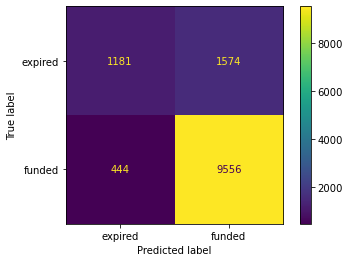

In [310]:
# showing predictions vs true status where 0=expired and 1=funded
num_cm = confusion_matrix(test_merged['actual'], test_merged['pred_num_funded'])
ConfusionMatrixDisplay(num_cm, display_labels = ['expired', 'funded']).plot();

In [311]:
print(classification_report(test_merged['actual'], test_merged['pred_num_funded']))

              precision    recall  f1-score   support

           0       0.73      0.43      0.54      2755
           1       0.86      0.96      0.90     10000

    accuracy                           0.84     12755
   macro avg       0.79      0.69      0.72     12755
weighted avg       0.83      0.84      0.83     12755



In [312]:
print(classification_report(test_merged['actual'], test_merged['nlp_pred']))

              precision    recall  f1-score   support

           0       0.69      0.32      0.43      2755
           1       0.84      0.96      0.89     10000

    accuracy                           0.82     12755
   macro avg       0.76      0.64      0.66     12755
weighted avg       0.80      0.82      0.79     12755



In [353]:
w1=0.9 #for numeric model
w2=0.1 #for nlp model

test_merged['comb_prob'] = (w1*test_merged['prob_num_funded'] + w2*test_merged['nlp_prob'])
test_merged['comb_pred'] = test_merged['comb_prob'].round()
test_merged.head()

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual,nlp_prob,nlp_pred,comb_prob,comb_pred
0,0.201414,0.798586,1,856646,1,0.900303,1,0.808758,1.0
1,0.844052,0.155948,0,1619503,0,0.410285,0,0.181381,0.0
2,0.034394,0.965606,1,1220577,1,0.968770,1,0.965922,1.0
3,0.263052,0.736948,1,909048,0,0.602169,1,0.723470,1.0
4,0.260310,0.739690,1,1843580,1,0.706473,1,0.736368,1.0


In [354]:
print(classification_report(test_merged['actual'], test_merged['comb_pred']))

              precision    recall  f1-score   support

           0       0.74      0.41      0.53      2755
           1       0.86      0.96      0.90     10000

    accuracy                           0.84     12755
   macro avg       0.80      0.69      0.72     12755
weighted avg       0.83      0.84      0.82     12755



In [355]:
#Creating report for Numeric model, NLP model and combined model
y_test=test_merged['actual']

preds = test_merged['pred_num_funded']
print('Scores from Numeric model')
print(f'Various scores:  AUROC: {roc_auc_score(y_test, preds)}, ACC_SCORE: {accuracy_score(y_test, preds)}, REC_SCORE: {recall_score(y_test, preds)}, PREC_SCORE: {precision_score(y_test, preds)},F1: {f1_score(y_test, preds)}')
print('**************')

preds = test_merged['nlp_pred']
print('Scores from NLP model')
print(f'Various scores:  AUROC: {roc_auc_score(y_test, preds)}, ACC_SCORE: {accuracy_score(y_test, preds)}, REC_SCORE: {recall_score(y_test, preds)}, PREC_SCORE: {precision_score(y_test, preds)},F1: {f1_score(y_test, preds)}')
print('**************')

preds = test_merged['comb_pred']
print('Scores from Combined model')
print(f'Various scores:  AUROC: {roc_auc_score(y_test, preds)}, ACC_SCORE: {accuracy_score(y_test, preds)}, REC_SCORE: {recall_score(y_test, preds)}, PREC_SCORE: {precision_score(y_test, preds)},F1: {f1_score(y_test, preds)}')
print('**************')

Scores from Numeric model
Various scores:  AUROC: 0.6921375680580762, ACC_SCORE: 0.8417875343002744, REC_SCORE: 0.9556, PREC_SCORE: 0.8585804132973944,F1: 0.9044959772834832
**************
Scores from NLP model
Various scores:  AUROC: 0.6386892014519057, ACC_SCORE: 0.8214817718541748, REC_SCORE: 0.9605, PREC_SCORE: 0.8361626186123444,F1: 0.8940289477358403
**************
Scores from Combined model
Various scores:  AUROC: 0.6854631578947368, ACC_SCORE: 0.8416307330458643, REC_SCORE: 0.9604, PREC_SCORE: 0.8553615960099751,F1: 0.9048426606368947
**************


In [341]:
test_merged.query('pred_num_funded != nlp_pred')

prob_num_notfunded    1275
prob_num_funded       1275
pred_num_funded       1275
LOAN_ID               1275
actual                1275
nlp_prob              1275
nlp_pred              1275
comb_prob             1275
comb_pred             1275
dtype: int64

In [350]:
test_merged.groupby(['pred_num_funded', 'nlp_pred', 'actual'])['LOAN_ID'].count()

pred_num_funded  nlp_pred  actual
0                0         0          645
                           1          164
                 1         0          536
                           1          280
1                0         0          228
                           1          231
                 1         0         1346
                           1         9325
Name: LOAN_ID, dtype: int64

In [360]:
test_merged.query('nlp_pred==1 & actual==0')

,prob_num_notfunded,prob_num_funded,pred_num_funded,LOAN_ID,actual,nlp_prob,nlp_pred,comb_prob,comb_pred
3,0.263052,0.736948,1,909048,0,0.602169,1,0.723470,1.0
5,0.681123,0.318877,0,1742232,0,0.578826,1,0.344872,0.0
15,0.219249,0.780751,1,1038206,0,0.712845,1,0.773961,1.0
32,0.334960,0.665040,1,1236109,0,0.934516,1,0.691988,1.0
43,0.206975,0.793025,1,1736095,0,0.944630,1,0.808186,1.0
...,...,...,...,...,...,...,...,...,...
12745,0.675210,0.324790,0,1144599,0,0.573089,1,0.349620,0.0
12746,0.549796,0.450204,0,1620055,0,0.528317,1,0.458015,0.0
12748,0.401188,0.598812,1,1391883,0,0.809775,1,0.619909,1.0
12751,0.225202,0.774798,1,1662020,0,0.516989,1,0.749017,1.0


In [362]:
kiva[kiva['LOAN_ID']==1736095]

,LOAN_ID,ORIGINAL_LANGUAGE,LOAN_AMOUNT,STATUS,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_CODE,LENDER_TERM,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,...,PIC_TRUE_COUNT,PIC_FALSE_COUNT,ANY_FEM,ANY_MALE,word_char_DT,word_char_TAGS,word_char_LU,MALE_FEM,MALE_PIC,FEM_PIC
1264,1736095,English,500.0,0,Farming,Agriculture,KE,14.0,monthly,field_partner,...,1.0,0.0,1.0,1.0,175565,172,1264,1.0,1.0,1.0


In [365]:
%alias

Total number of aliases: 8


[('copy', 'copy'),
 ('ddir', 'dir /ad /on'),
 ('echo', 'echo'),
 ('ldir', 'dir /ad /on'),
 ('ls', 'dir /on'),
 ('mkdir', 'mkdir'),
 ('ren', 'ren'),
 ('rmdir', 'rmdir')]